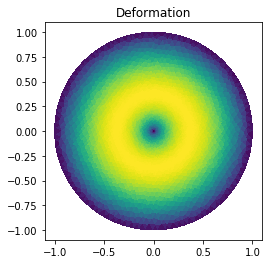

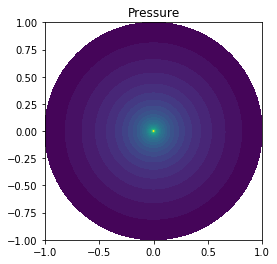

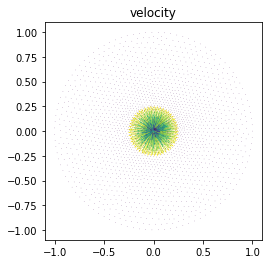

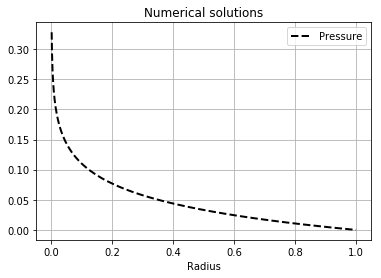

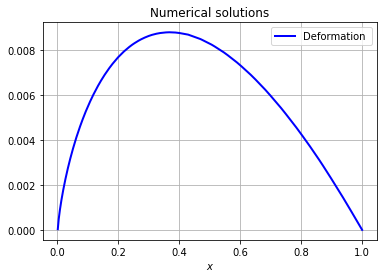

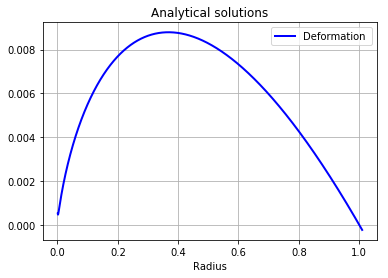

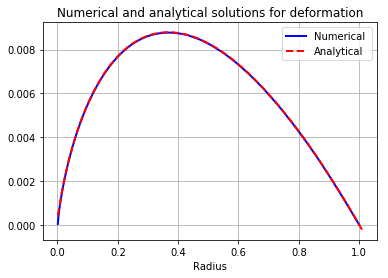

In [2]:
from dolfin import *
from ufl import nabla_div
import matplotlib.pyplot as plt

import fenics as fe
import matplotlib.pyplot as plt
import numpy as np
import ufl
import sys


##############################################################################
mesh = Mesh('Circle_hole_small.xml')
subdomains = MeshFunction("size_t", mesh, "Circle_hole_small_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "Circle_hole_small_facet_region.xml")

# Write HDF5
#hdf = HDF5File(mesh.mpi_comm(), "Circle_hole.h5", "w")
hdf = HDF5File(mesh.mpi_comm(), "Circle_hole_small.h5", "w")
hdf.write(mesh, "/mesh")
hdf.write(subdomains, "/subdomains")
hdf.write(boundaries, "/boundaries")

mesh = Mesh()
#hdf = HDF5File(mesh.mpi_comm(), "Circle_hole.h5", "r")
hdf = HDF5File(mesh.mpi_comm(), "Circle_hole_small.h5", "r")
hdf.read(mesh, "/mesh", False)
sub_domains = MeshFunction("size_t", mesh, 1)    #--> 1 is dimension for curve
hdf.read(sub_domains, "/boundaries")

# Measures and integration points
boundaries = sub_domains
#dx = dx(metadata={'quadrature_degree': q_degree})
#ds = ds(subdomain_data=boundaries, metadata={'quadrature_degree': q_degree})
ds = ds(subdomain_data=boundaries)

#do it via MixedElement which luckily is not deprecated so far:
P_u = VectorElement("Lagrange", mesh.ufl_cell(), 1)
P_p = FiniteElement("Lagrange", mesh.ufl_cell(), 1)


# Define the mixed element
W_elem = MixedElement([P_u, P_p])
# Define the mixed function space
W = FunctionSpace(mesh, W_elem)
##############################################################################
#Define Dirichlet boundary conditions
#W.sub(0) --> displacement and W.sub(1) --> pressure 
outer_boundary_pressure = DirichletBC(W.sub(1), Constant((0.0)), boundaries, 2)
outer_boundary_displacement = DirichletBC(W.sub(0), Constant((0.0,0.0)), boundaries, 2)
bcs = [outer_boundary_pressure, outer_boundary_displacement]

##############################################################################
# Define strain and stress
def epsilon(u):
    E = 0.5*(nabla_grad(u) + nabla_grad(u).T)
    return E

def sigma(u,p):
    
    d = u.geometric_dimension()
    I = Identity(d)             # Identity tensor
    S = 2*G*epsilon(u)+(2*G*nu)/(1-2*nu)*tr(epsilon(u))*I-p*I
    
    return S

##############################################################################
# Define trial and test functions
(u, p) = TrialFunctions(W)
(q, v) = TestFunctions(W)


E, nu = 0.770, 0.4/1.4  
G = Constant(E/(2*(1 + nu)))    #shear modulus mu

##stress tensor 
Stress = sigma(u,p)

##Momentum balance
B  = Constant((0.0, 0.0))
T = Constant(0.0)
n = FacetNormal(mesh)
Tr = T*n

a1 = inner(Stress,grad(q))*dx
L1 = inner(B, q)*dx #+ inner(Tr,q)*ds(3)


#Add L of fluid problem
f = Constant(0.0)
k = Constant(1.0)
pressure_drop = 0.33
r1 = 0.001
r2 = 1.0
g1 = Constant(-pressure_drop/(r1*(ln(r1)-ln(r2))))   #g1 --> inner boundary (3)
A1 = 2.0*pi*0.001
A2 = 2.0*pi*1.0
g2 = -g1*(A1/A2)                      #g2 --> outer boundary (2)
a2 = k*inner(grad(p), grad(v))*dx
#L2 = f*v*dx + g1*v*ds(3) + g2*v*ds(2)
L2 = f*v*dx + g1*v*ds(3)  


#State full problem
a = a1 + a2
L = L1 + L2

##############################################################################
## Solve variational problem
w_coupled = Function(W)
solve(a == L, w_coupled, bcs)
(u, p) = w_coupled.split()

plot(u, mode="displacement", title='Deformation')
plt.show()

plot(p, title='Pressure')
plt.show()


w = -k*grad(p)
plot(w, title='velocity')
plt.show()
##############################################################################
# Curve plot
import numpy as np
import matplotlib.pyplot as plt
tol = 0.00001  # avoid hitting points outside the domain
#x = np.linspace(0.5 + tol, 3.0 - tol, 100)
x = np.linspace(0.001 + tol, 1.0 - tol, 1000)
points = [(x_,0) for x_ in x]  # 2D points
#points
#u_line = np.array([sqrt(u(point)[0]**2+u(point)[1]**2) for point in points])
p_line = np.array([p(point) for point in points])
plt.title("Numerical solutions") 
plt.xlabel("Radius") 
#plt.plot(x, u_line, 'b', linewidth=2)  
plt.plot(x, p_line, 'k--', linewidth=2)
plt.grid(True)
#pyplot.xscale('log')
#plt.xlabel('$x$')
#plt.legend(['Deformation ', 'Pressure'], loc='upper right')
plt.legend(['Pressure'], loc='upper right')
plt.show()


u_line = np.array([sqrt(u(point)[0]**2+u(point)[1]**2) for point in points])
plt.title("Numerical solutions") 
plt.xlabel("Radius") 
plt.plot(x, u_line, 'b', linewidth=2)  
plt.grid(True)
plt.xlabel('$x$')
plt.legend(['Deformation '], loc='upper right')
plt.show()


#Analytical solution
from matplotlib import pyplot
r_0 = 0.001
#r_0 = 0.85
r_max = 1.01
#r_0 = 0.5
#r_max = 3.01
r = np.arange(r_0,r_max,0.0001) 
Gamma = 0.4
q = 0.0478
#q = 0.1538
B1 = -(1-Gamma)*((q*(1+(1+Gamma)*np.log(r_0)))/(2*(((r_0)**2)*(1+Gamma)+(1-Gamma))))+((1+Gamma)/2)*q*np.log(r_0)
B2 = -(1-Gamma)*((q*(r_0)**2*(1+(1+Gamma)*np.log(r_0)))/(2*(((r_0)**2)*(1+Gamma)+(1-Gamma))))
u_analytic = (-q*r*np.log(r))/(2)+((2*B1+q)*r)/(2*(1+Gamma))+(B2)/((1-Gamma)*r)
#u_analytic = -(1/4)*con*r**2 + k1*np.log(r)+k2
plt.title("Analytical solutions") 
plt.xlabel("Radius") 
#plt.ylabel("Deformation") 
plt.plot(r,u_analytic, 'b', linewidth=2) 
plt.grid(True)
#pyplot.xscale('log')
#plt.ylim((0,0.06))
#sigma_r_analytical = -(1+Gamma)/(2)*q*np.log(r_0)+B1-B2/(r**2)
#plt.plot(r, sigma_r_analytical, 'k--', linewidth=2)
plt.legend(['Deformation '], loc='upper right')
plt.show()


plt.title("Numerical and analytical solutions for deformation") 
plt.xlabel("Radius") 
plt.plot(x, u_line, 'b', linewidth=2)
plt.plot(r,u_analytic, 'r--', linewidth=2) 
plt.grid(True)
plt.legend(['Numerical ','Analytical'], loc='upper right')
plt.show()
##############################################################################
# Save solution in VTK format
file = File("Linear_Coupled_problem_displacement.pvd");
file << u;

file = File("Linear_Coupled_problem_pressure.pvd")
file << p

# Save solution in VTK format
V_velocity = VectorFunctionSpace(mesh, "CG", degree = 1)
velocity = Function(V_velocity, name="velocity")
velocity.assign(project(w, V_velocity))
file = File("Linear_Coupled_problem_velocity.pvd")
file << velocity

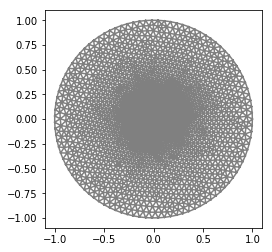

In [3]:
plot(mesh)